In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from typing import Tuple
import random
import artifact
import sampler
import char
import damage

from IPython import display

In [2]:
# Diluc base stats at A5 L80. With Lvl 90 prototype archaic.
base = [
    0, 11453,
    0, 692,
    0 + 276, 295 + 565,
    194, 500,
    0, 0,
    0, 0, 0, 0, 0, 0, 0, 0, 0,
]
base = np.array(base, dtype=np.float32)

formula = sum([damage.DilucN1(i) for i in range(4)])
c = char.Character(char.Stats(base), formula)

In [3]:
c.artis = [None for _ in range(5)]
f'Base dmg: {c.eval()}'

'Base dmg: 7174.671286138608'

In [11]:
class CumSolver:
    def __init__(self, stats, dmg):
        self.c = char.Character(stats, dmg)
        self.artis = []
        
        self.eqset = [None for _ in range(5)]
        self.cur_dmg = c.eval()
    
    def advance(self):
        a = artifact.make_arti()
        self.artis.append(a)
        
        # solver step
        self.c.equip(a)
        new_dmg = self.c.eval()
        if new_dmg >= self.cur_dmg:
            self.eqset[a.slot] = a
            self.cur_dmg = new_dmg
        else:
            self.c.equip(self.eqset)
        return self.cur_dmg

In [41]:
curves = []

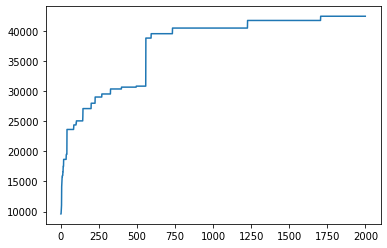

In [79]:
for _ in range(50):
    slv = CumSolver(char.Stats(base), formula)
    vss = np.array([slv.advance() for _ in range(2000)])
    curves.append(vss)
plt.plot(vss)

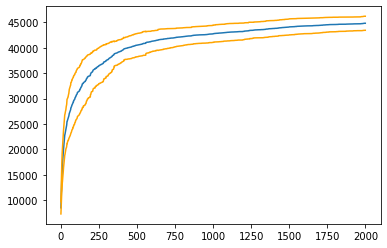

In [80]:
m = np.mean(curves, axis=0)
s = np.std(curves, axis=0)
plt.plot(m)
plt.plot(m + s, color='orange')
plt.plot(m - s, color='orange')

In [37]:
np.argsort(vss[1:] - vss[:-1])[::-1]

array([ 112,   19,    1, ..., 1336, 1337,  999])

In [32]:
vss[112], vss[113]

(27286.364579186775, 31743.08867826028)

In [33]:
slv.artis[113]

Phys Cup@(HP:269>867, DEF:16>32, ER:0>110, EM:23>23)

In [95]:
eqset = [None for _ in range(5)]
c.artis = eqset.copy()
cur_dmg = c.eval()

artis = []
for _ in range(100):
    a = artifact.make_arti()
    artis.append(a)
    c.equip(a)
    
    new_dmg = c.eval()
    if new_dmg >= cur_dmg:
        eqset[a.slot] = a
        cur_dmg = new_dmg
    else:
        c.equip(eqset)
cur_dmg

34954.41928656727

In [96]:
print(f'Dmg: {c.eval(eqset)}')
for ts in ['ATK', 'CR', 'CD']:
    print(f'  {ts}: {c._bake_stats()[ts]}')
eqset

Dmg: 34954.41928656727
  ATK: 2511.1201171875
  CR: 0.3840000033378601
  CD: 1.2380000352859497


[HP Flower@(DEF:0>21, ATK%:58>99, ATK:14>30, CD:62>186),
 ATK Feath@(HP%:41>41, ATK%:41>135, CR:0>97, ER:65>65),
 ATK% Sands@(HP%:53>53, ATK:0>28, CD:70>202, EM:16>39),
 Phys Cup@(HP:269>269, ATK:0>28, CD:62>132, ER:52>156),
 ATK% Hat@(HP:239>239, ATK:14>14, CR:27>93, CD:0>218)]

In [78]:
print(f'Dmg: {c.eval(eqset)}')
for ts in ['ATK', 'CR', 'CD']:
    print(f'  {ts}: {c._bake_stats()[ts]}')
eqset

Dmg: 51990.25112449387
  ATK: 2194.360107421875
  CR: 0.8159999847412109
  CD: 1.8519999980926514


[HP Flower@(ATK%:41>152, ATK:18>18, CR:35>144, CD:54>54),
 ATK Feath@(ATK%:58>116, CR:31>62, CD:54>280, EM:19>19),
 ATK% Sands@(HP:209>209, DEF%:73>73, CR:27>101, CD:54>264),
 Phys Cup@(HP%:41>41, ATK:19>19, CR:35>179, CD:62>132),
 CD Hat@(DEF:16>39, ATK%:58>116, ATK:18>18, CR:39>136)]

In [74]:
print(f'Dmg: {c.eval(eqset)}')
for ts in ['ATK', 'CR', 'CD']:
    print(f'  {ts}: {c._bake_stats()[ts]}')
eqset

Dmg: 52511.063832588814
  ATK: 2221.47998046875
  CR: 0.9480000138282776
  CD: 1.5880000591278076


[HP Flower@(DEF:19>19, ATK%:53>53, CR:39>179, CD:62>132),
 ATK Feath@(DEF:19>19, ATK%:58>163, CR:35>97, CD:70>132),
 ATK% Sands@(HP%:58>58, ATK:16>16, CR:35>179, CD:78>148),
 Phys Cup@(HP%:58>58, ATK%:47>163, CR:27>124, CD:54>54),
 CD Hat@(ATK%:47>47, ATK:16>30, CR:39>175, EM:23>23)]

In [65]:
print(f'Dmg: {c.eval(eqset)}')
eqset

Dmg: 53961.627858173


[HP Flower@(ATK%:53>53, ATK:18>18, CR:35>35, CD:70>428),
 ATK Feath@(DEF:21>21, ATK%:58>58, CR:35>132, CD:78>218),
 ATK% Sands@(HP:299>299, DEF:16>16, CR:27>105, CD:78>288),
 Phys Cup@(HP:239>239, ATK%:41>204, CR:39>109, CD:78>78),
 CR Hat@(HP%:58>58, ATK%:47>158, ATK:19>37, CD:70>202)]

In [70]:
c._bake_stats()

[0.0000000e+00 1.7435273e+04 0.0000000e+00 7.2900000e+02 0.0000000e+00
 2.2708999e+03 8.8599998e-01 1.7140000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.8300000e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]

In [14]:
%timeit c.eval()

173 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
a = artifact.make_arti()

In [12]:
a

ATK% Hat@(HP:0>418, DEF%:66>66, CD:54>240, EM:16>16)

In [10]:
c.artis[4] = a

In [2]:
a1 = artifact.make_arti()
a2 = artifact.make_arti()
a1, a2

(ATK% Sands@(HP%:58>198, DEF:19>19, CD:0>156, EM:23>23),
 CR Hat@(HP:239>508, DEF%:66>212, ATK:19>37, CD:70>124))

In [3]:
s = char.Stats()

In [5]:
a1 + a2

[198 508 212  19 466  37 311 280   0  23   0   0   0   0   0   0   0   0
   0]

In [47]:
%timeit artifact.make_arti()

137 µs ± 13.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [1099]:
slotnames = ['Flower', 'Feath', 'Sands', 'Cup', 'Circ']
# statnames = ['CR', 'CD', 'ER', 'EM', 'ATK%', 'ATK', 'HP%', 'HP', 'DEF%', 'DEF', 'Heal',
statnames = ['HP%', 'HP', 'DEF%', 'DEF', 'ATK%', 'ATK', 'CR', 'CD', 'ER', 'EM', 'Heal',
          'Phys', 'Hydro', 'Pyro', 'Cryo', 'Electro', 'Anemo', 'Geo', 'Dendro']
statmap = {n: i for i, n in enumerate(statnames)}